# CSCIE89 Stacked Models "Autoencoder + RF" & "Autoencoder + LR"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# load the data
data_loaded = False

from pathlib import Path
file_path = Path("./bank_marketing_dataset.csv")

if file_path.is_file():
    print(f"The data file '{file_path}' exists.")
    data_loaded = True
else:
    print(f"The file '{file_path}' does not exist or is not a regular file.")
    data_loaded = False

if not data_loaded:
    try:
        import urllib.request
        import zipfile
        import io

        print("Downloading from UCI repository...")
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"

        # Download the zip file
        with urllib.request.urlopen(url) as response:
            zip_data = response.read()

        # Extract and read the CSV
        with zipfile.ZipFile(io.BytesIO(zip_data)) as zip_ref:
            # Use the full dataset (bank-additional-full.csv)
            with zip_ref.open('bank-additional/bank-additional-full.csv') as csv_file:
                df = pd.read_csv(csv_file, sep=';')

        print(f"Successfully loaded dataset with {len(df)} rows")

        # Separate features and target
        X = df.drop('y', axis=1)
        y = df['y'].values
        data_loaded = True

        dataset_df = X.copy()
        dataset_df['target'] = y
        #dataset_df.to_csv('bank_marketing_dataset.csv', index=False)
        print(f" Dataset saved to 'bank_marketing_dataset.csv'")


    except Exception as e:
        print(f"Direct download failed: {e}")
else :
        df = pd.read_csv(file_path, sep=',')

        print(f"Successfully loaded dataset with {len(df)} rows")

        # Separate features and target
        X = df.drop('target', axis=1)
        y = df['target'].values

        dataset_df = X.copy()
        dataset_df['target'] = y
        data_loaded = True

# Save dataset to CSV



The file 'bank_marketing_dataset.csv' does not exist or is not a regular file.
Successfully loaded dataset with 41188 rows
 Dataset saved to 'bank_marketing_dataset.csv'


In [3]:
print(f"\nFeature columns: {list(X.columns)}")
print(f"\nTarget variable (y): Subscribe term deposit")
print(f"Class distribution:\n{pd.Series(y).value_counts()}")



Feature columns: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

Target variable (y): Subscribe term deposit
Class distribution:
no     36548
yes     4640
Name: count, dtype: int64


In [4]:
# Perform EDA
print("\n" + "="*70)
print("EXPLORATORY DATA ANALYSIS (EDA)")
print("="*70)

print("\n1. DATASET OVERVIEW:")
print("-" * 70)
print(dataset_df.info())

print("\n2. STATISTICAL SUMMARY:")
print("-" * 70)
print(dataset_df.describe())

print("\n3. MISSING VALUES:")
print("-" * 70)
missing = dataset_df.isnull().sum()
if missing.sum() == 0:
    print("No missing values found!")
else:
    print(missing[missing > 0])

print("\n4. FEATURE DETAILS:")
print("-" * 70)
for i, col in enumerate(X.columns, 1):
    dtype = X[col].dtype
    unique_count = X[col].nunique()
    print(f"{i:2d}. {col:20s} | Type: {str(dtype):10s} | Unique values: {unique_count:5d}")

    if unique_count <= 10:  # Show distribution for categorical features
        print(f"    Distribution: {dict(X[col].value_counts().head())}")

print("\n5. TARGET VARIABLE ANALYSIS:")
print("-" * 70)
target_counts = pd.Series(y).value_counts()
target_pct = pd.Series(y).value_counts(normalize=True) * 100
print(f"Class distribution:")
for cls, count in target_counts.items():
    pct = target_pct[cls]
    print(f"  {cls}: {count:6d} ({pct:5.2f}%)")
print(f"\nClass imbalance ratio: {target_counts.max() / target_counts.min():.2f}:1")



EXPLORATORY DATA ANALYSIS (EDA)

1. DATASET OVERVIEW:
----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 



Generating EDA visualizations...
EDA visualization saved as 'bank_marketing_eda.png'


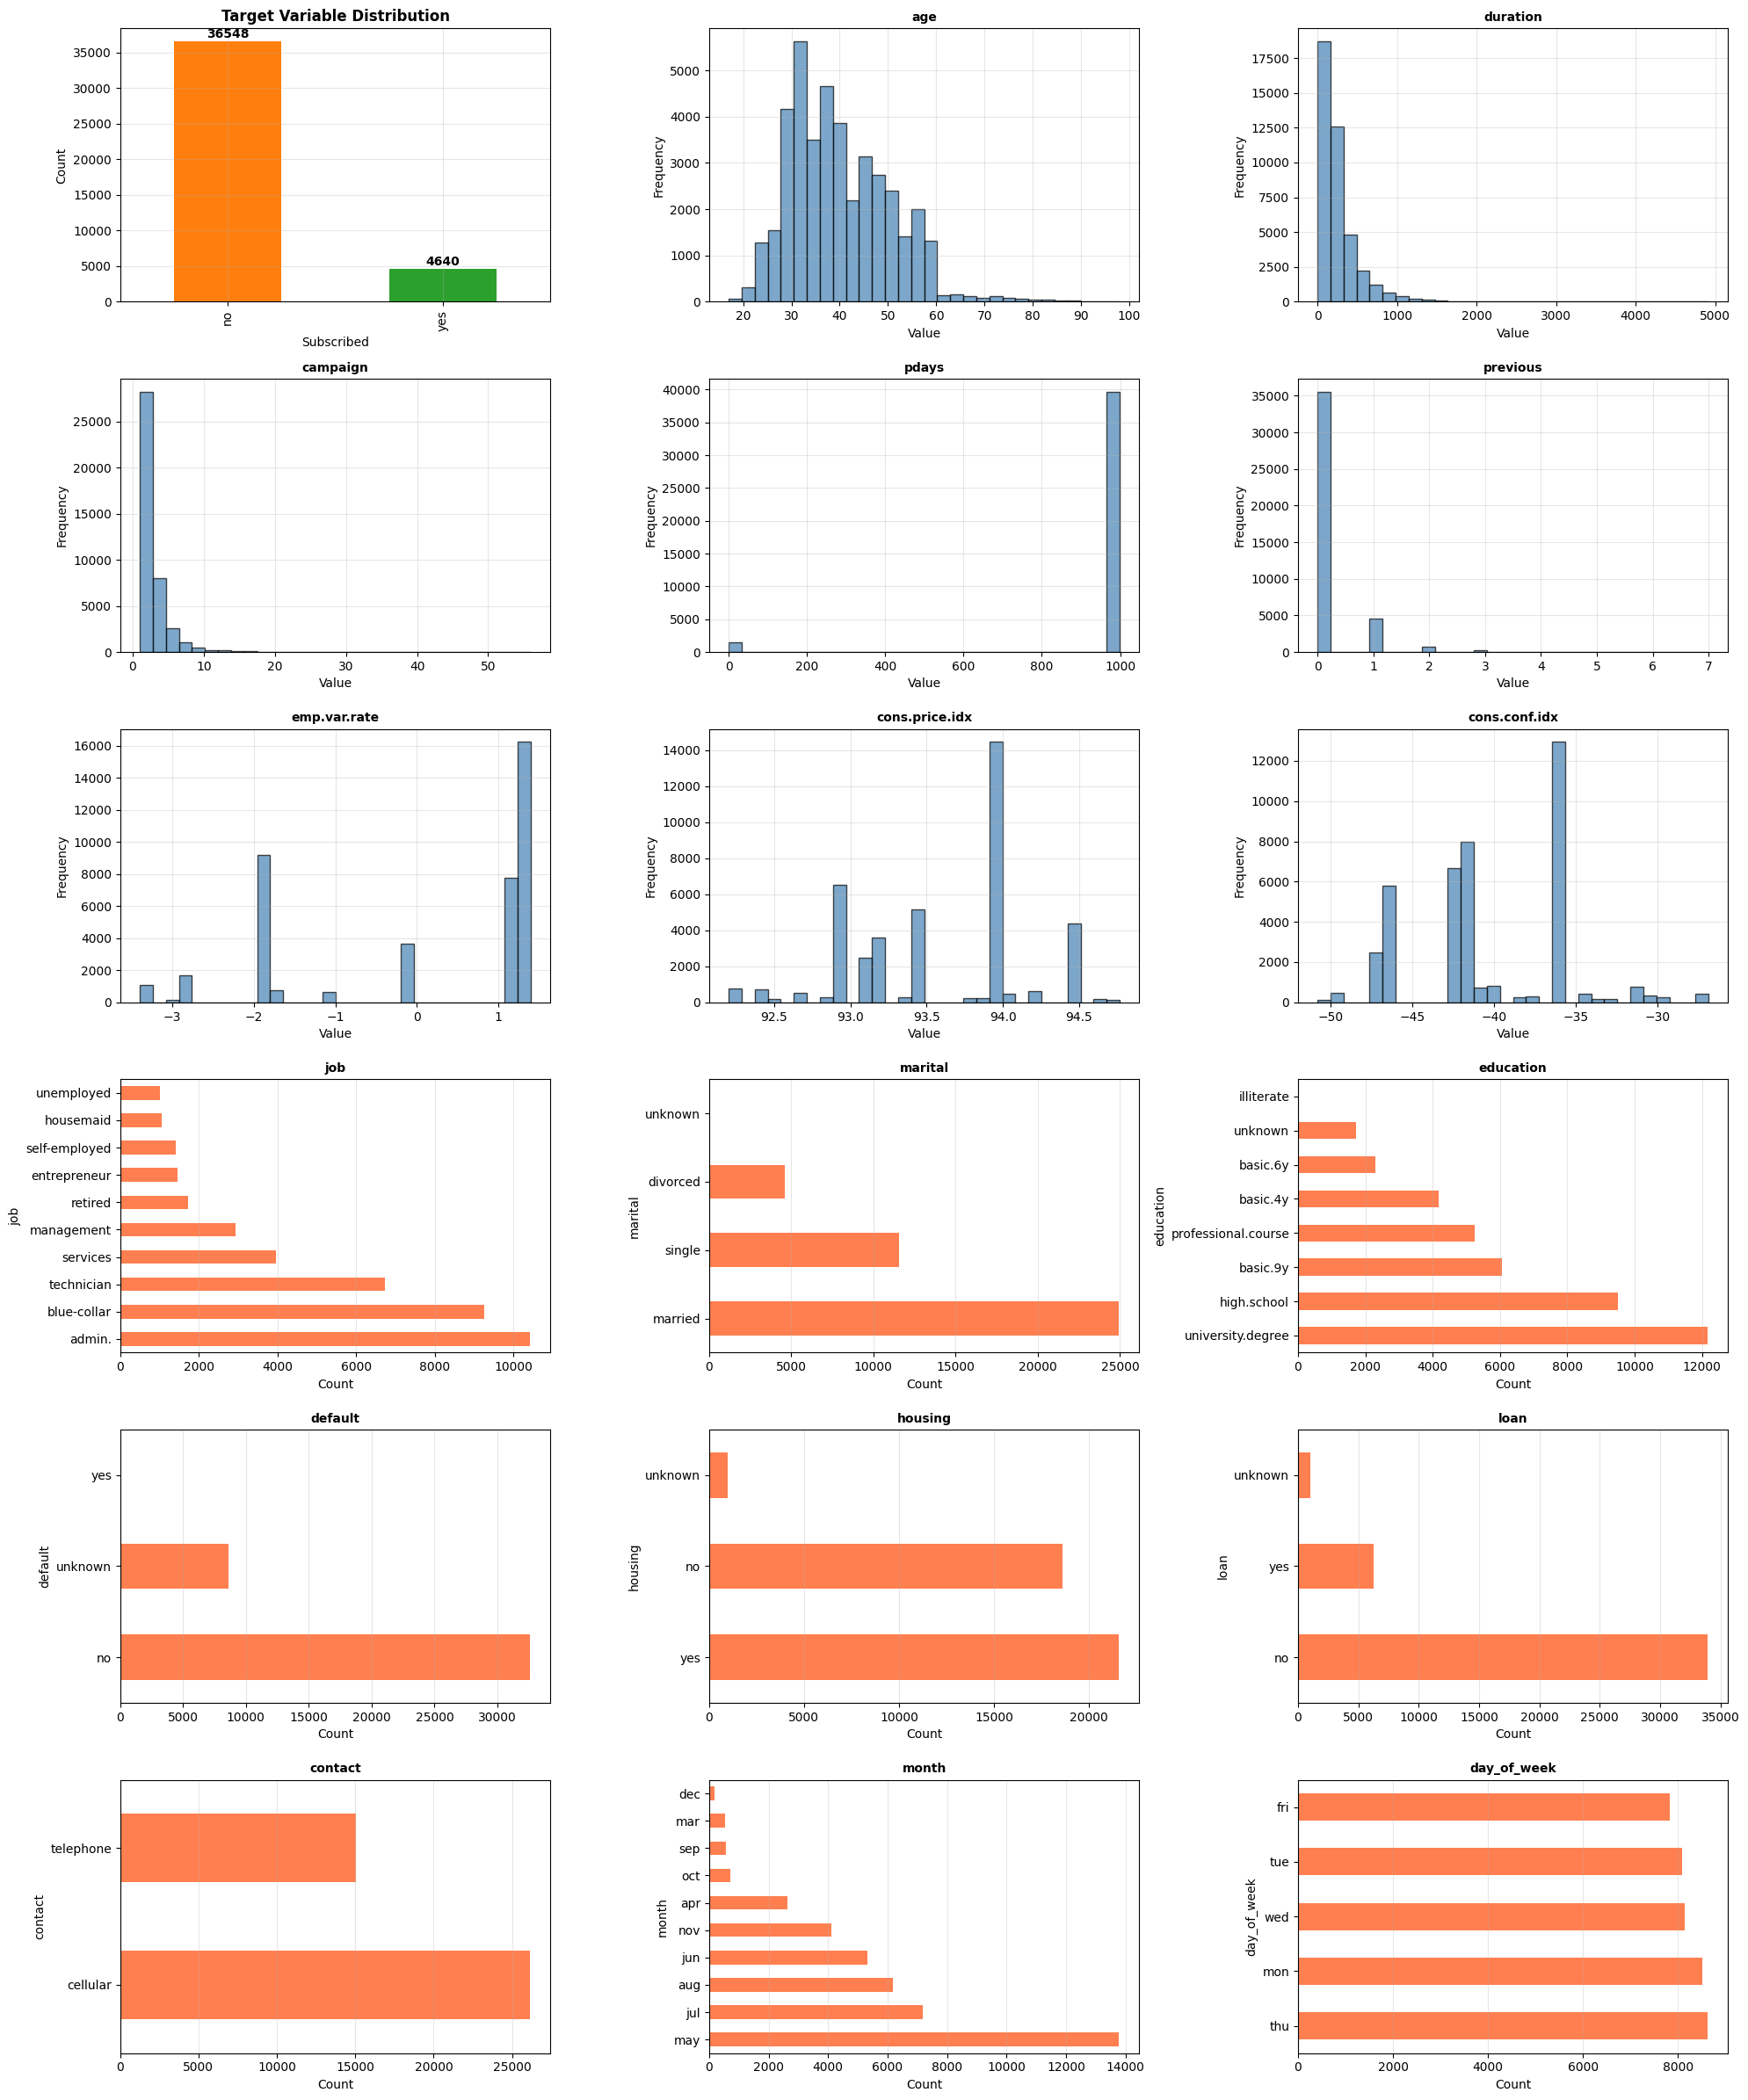

In [6]:
# Create comprehensive EDA visualizations
print("\nGenerating EDA visualizations...")
fig = plt.figure(figsize=(20, 24))

# 1. Target distribution
ax1 = plt.subplot(6, 3, 1)
target_counts.plot(kind='bar', ax=ax1, color=['#ff7f0e', '#2ca02c'])
ax1.set_title('Target Variable Distribution', fontsize=12, fontweight='bold')
ax1.set_xlabel('Subscribed')
ax1.set_ylabel('Count')
ax1.grid(True, alpha=0.3)
for i, v in enumerate(target_counts):
    ax1.text(i, v + 500, str(v), ha='center', fontweight='bold')

# 2. Numerical features distribution
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
for idx, col in enumerate(numerical_cols[:8], 2):  # First 8 numerical features
    ax = plt.subplot(6, 3, idx)
    ax.hist(X[col].dropna(), bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax.set_title(f'{col}', fontsize=10, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

# 3. Categorical features distribution
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
plot_idx = 10
for col in categorical_cols[:9]:  # First 9 categorical features
    ax = plt.subplot(6, 3, plot_idx)
    value_counts = X[col].value_counts().head(10)  # Top 10 categories
    value_counts.plot(kind='barh', ax=ax, color='coral')
    ax.set_title(f'{col}', fontsize=10, fontweight='bold')
    ax.set_xlabel('Count')
    ax.grid(True, alpha=0.3, axis='x')
    plot_idx += 1

plt.tight_layout()
plt.savefig('bank_marketing_eda.png', dpi=150, bbox_inches='tight')
print("EDA visualization saved as 'bank_marketing_eda.png'")
plt.show()



6. CORRELATION ANALYSIS:
----------------------------------------------------------------------
✓ Correlation matrix saved as 'bank_marketing_correlation.png'


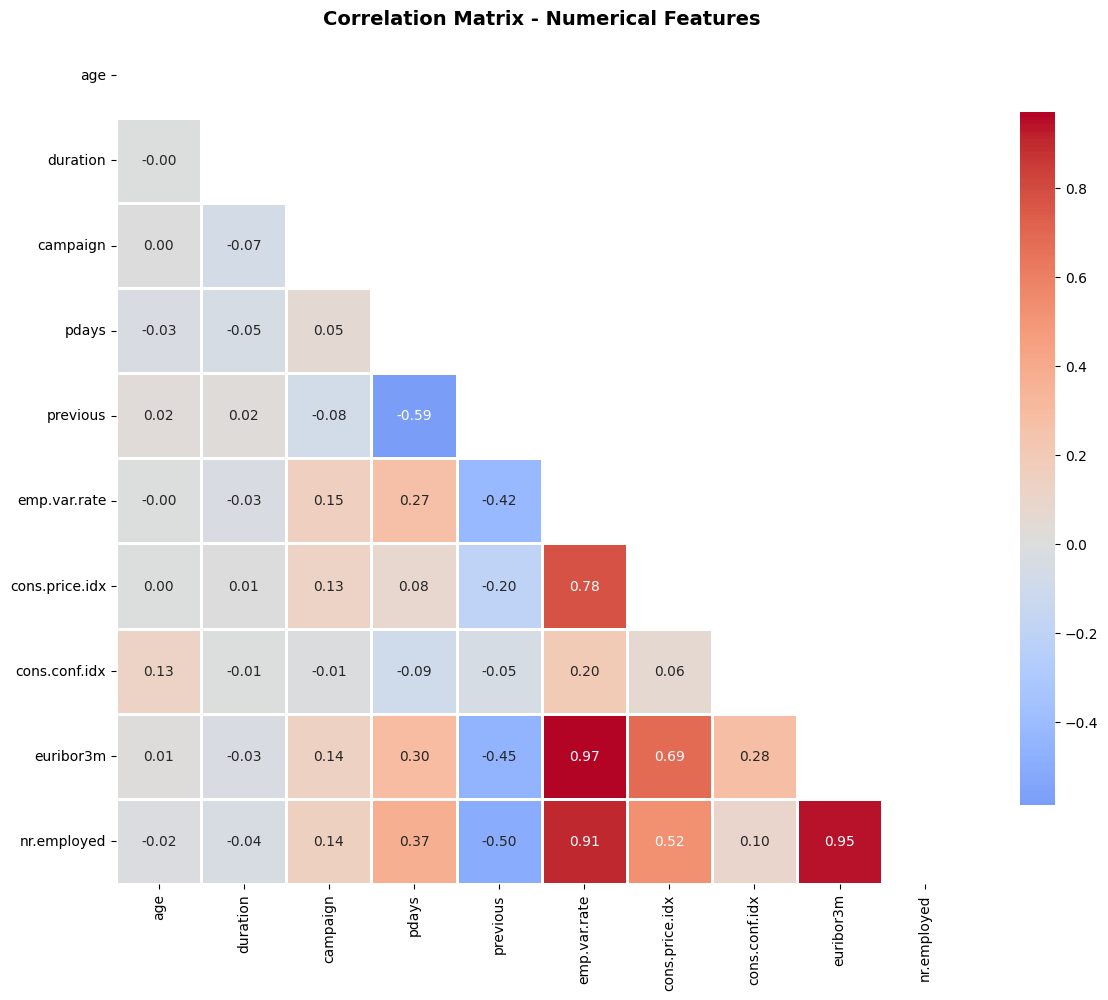


High correlations (|r| > 0.5):
  emp.var.rate         ↔ euribor3m           :  0.972
  euribor3m            ↔ nr.employed         :  0.945
  emp.var.rate         ↔ nr.employed         :  0.907
  emp.var.rate         ↔ cons.price.idx      :  0.775
  cons.price.idx       ↔ euribor3m           :  0.688
  pdays                ↔ previous            : -0.588
  cons.price.idx       ↔ nr.employed         :  0.522
  previous             ↔ nr.employed         : -0.501



In [7]:
# Correlation matrix for numerical features
if len(numerical_cols) > 0:
    print("\n6. CORRELATION ANALYSIS:")
    print("-" * 70)

    fig_corr = plt.figure(figsize=(12, 10))
    corr_matrix = X[numerical_cols].corr()

    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
                cmap='coolwarm', center=0, square=True,
                linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix - Numerical Features', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('bank_marketing_correlation.png', dpi=150, bbox_inches='tight')
    print("✓ Correlation matrix saved as 'bank_marketing_correlation.png'")
    plt.show()

    # Print high correlations
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.5:
                high_corr.append((corr_matrix.columns[i],
                                corr_matrix.columns[j],
                                corr_matrix.iloc[i, j]))

    if high_corr:
        print("\nHigh correlations (|r| > 0.5):")
        for feat1, feat2, corr_val in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True):
            print(f"  {feat1:20s} ↔ {feat2:20s}: {corr_val:6.3f}")
    else:
        print("\nNo high correlations found (|r| > 0.5)")

print("\n" + "="*70)

In [8]:
# 2. Preprocess the data
print("\n" + "="*70)
print("PREPROCESSING")
print("="*70)

# Encode target variable to binary (0/1)
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
print(f"Target classes: {le_target.classes_}")

# Separate numerical and categorical features
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical features ({len(numerical_cols)}): {numerical_cols}")
print(f"Categorical features ({len(categorical_cols)}): {categorical_cols}")

# Encode categorical variables
X_encoded = X.copy()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

print(f"\nAfter encoding: {X_encoded.shape[1]} total features")




PREPROCESSING
Target classes: ['no' 'yes']

Numerical features (10): ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical features (10): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

After encoding: 20 total features


In [9]:
# Convert to numpy array
X_array = X_encoded.values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_array, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Further split for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, stratify=y_train
)


In [10]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining samples: {X_train.shape[0]:,}")
print(f"Validation samples: {X_val.shape[0]:,}")
print(f"Test samples: {X_test.shape[0]:,}")
print(f"Class balance (train): {np.bincount(y_train)}")



Training samples: 28,007
Validation samples: 4,943
Test samples: 8,238
Class balance (train): [24852  3155]


Baseline Model : Random Forest

In [11]:
#  Classification on Original Features (Baseline)
print("\n" + "="*70)
print("BASELINE: CLASSIFICATION ON ORIGINAL FEATURES USING RF ")
print("="*70)

start_time = time.time()
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_baseline.fit(X_train_scaled, y_train)
baseline_time = time.time() - start_time
y_pred_baseline = rf_baseline.predict(X_test_scaled)
y_proba_baseline = rf_baseline.predict_proba(X_test_scaled)[:, 1]

baseline_acc = accuracy_score(y_test, y_pred_baseline)
baseline_auc = roc_auc_score(y_test, y_proba_baseline)

print(f"Training time: {baseline_time:.2f}s")
print(f"Accuracy: {baseline_acc:.4f}")
print(f"ROC AUC: {baseline_auc:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_baseline))


BASELINE: CLASSIFICATION ON ORIGINAL FEATURES USING RF 
Training time: 3.13s
Accuracy: 0.9190
ROC AUC: 0.9504

Confusion Matrix:
[[7089  221]
 [ 446  482]]


AutoEncoder

In [12]:
# 3. Build Autoencoder
print("\n" + "="*70)
print("BUILDING AUTOENCODER")
print("="*70)

input_dim = X_train_scaled.shape[1]
encoding_dim = 2  # 2D for visualization

# Encoder
encoder_input = layers.Input(shape=(input_dim,))
x = layers.Dense(64, activation='relu')(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.BatchNormalization()(x)
encoded = layers.Dense(encoding_dim, activation='linear', name='bottleneck')(x)

# Decoder
x = layers.Dense(16, activation='relu')(encoded)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
decoded = layers.Dense(input_dim, activation='linear')(x)

# Models
autoencoder = keras.Model(encoder_input, decoded, name='autoencoder')
encoder = keras.Model(encoder_input, encoded, name='encoder')

optimizer = keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

print(f"Autoencoder parameters: {autoencoder.count_params():,}")
print(f"Compression: {input_dim} features → {encoding_dim} embeddings ({input_dim/encoding_dim:.1f}x reduction)")



BUILDING AUTOENCODER
Autoencoder parameters: 8,886
Compression: 20 features → 2 embeddings (10.0x reduction)


In [13]:
# 4. Train Autoencoder
print("\n" + "="*70)
print("TRAINING AUTOENCODER")
print("="*70)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1)
]

start_time = time.time()
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=50,
    batch_size=256,
    validation_data=(X_val_scaled, X_val_scaled),
    callbacks=callbacks,
    verbose=2
)
training_time = time.time() - start_time

print(f"\nTraining completed in {training_time:.2f} seconds")
print(f"Final training loss: {history.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.6f}")



TRAINING AUTOENCODER
Epoch 1/50
110/110 - 7s - 67ms/step - loss: 1.2505 - mae: 0.8469 - val_loss: 0.8192 - val_mae: 0.6999 - learning_rate: 1.0000e-03
Epoch 2/50
110/110 - 1s - 7ms/step - loss: 0.8135 - mae: 0.6763 - val_loss: 0.6435 - val_mae: 0.5866 - learning_rate: 1.0000e-03
Epoch 3/50
110/110 - 1s - 7ms/step - loss: 0.7358 - mae: 0.6313 - val_loss: 0.6016 - val_mae: 0.5468 - learning_rate: 1.0000e-03
Epoch 4/50
110/110 - 1s - 7ms/step - loss: 0.6986 - mae: 0.6076 - val_loss: 0.5814 - val_mae: 0.5330 - learning_rate: 1.0000e-03
Epoch 5/50
110/110 - 1s - 11ms/step - loss: 0.6753 - mae: 0.5926 - val_loss: 0.5663 - val_mae: 0.5203 - learning_rate: 1.0000e-03
Epoch 6/50
110/110 - 1s - 7ms/step - loss: 0.6598 - mae: 0.5826 - val_loss: 0.5552 - val_mae: 0.5146 - learning_rate: 1.0000e-03
Epoch 7/50
110/110 - 1s - 7ms/step - loss: 0.6433 - mae: 0.5740 - val_loss: 0.5479 - val_mae: 0.5095 - learning_rate: 1.0000e-03
Epoch 8/50
110/110 - 1s - 8ms/step - loss: 0.6329 - mae: 0.5683 - val_los

In [14]:
# 5. Extract embeddings
print("\n" + "="*70)
print("EXTRACTING EMBEDDINGS")
print("="*70)

train_embeddings = encoder.predict(X_train_scaled, batch_size=1024, verbose=0)
val_embeddings = encoder.predict(X_val_scaled, batch_size=1024, verbose=0)
test_embeddings = encoder.predict(X_test_scaled, batch_size=1024, verbose=0)
print("Embeddings extracted successfully!")



EXTRACTING EMBEDDINGS
Embeddings extracted successfully!



Creating visualizations...
Visualization saved as 'bank_marketing_autoencoder.png'


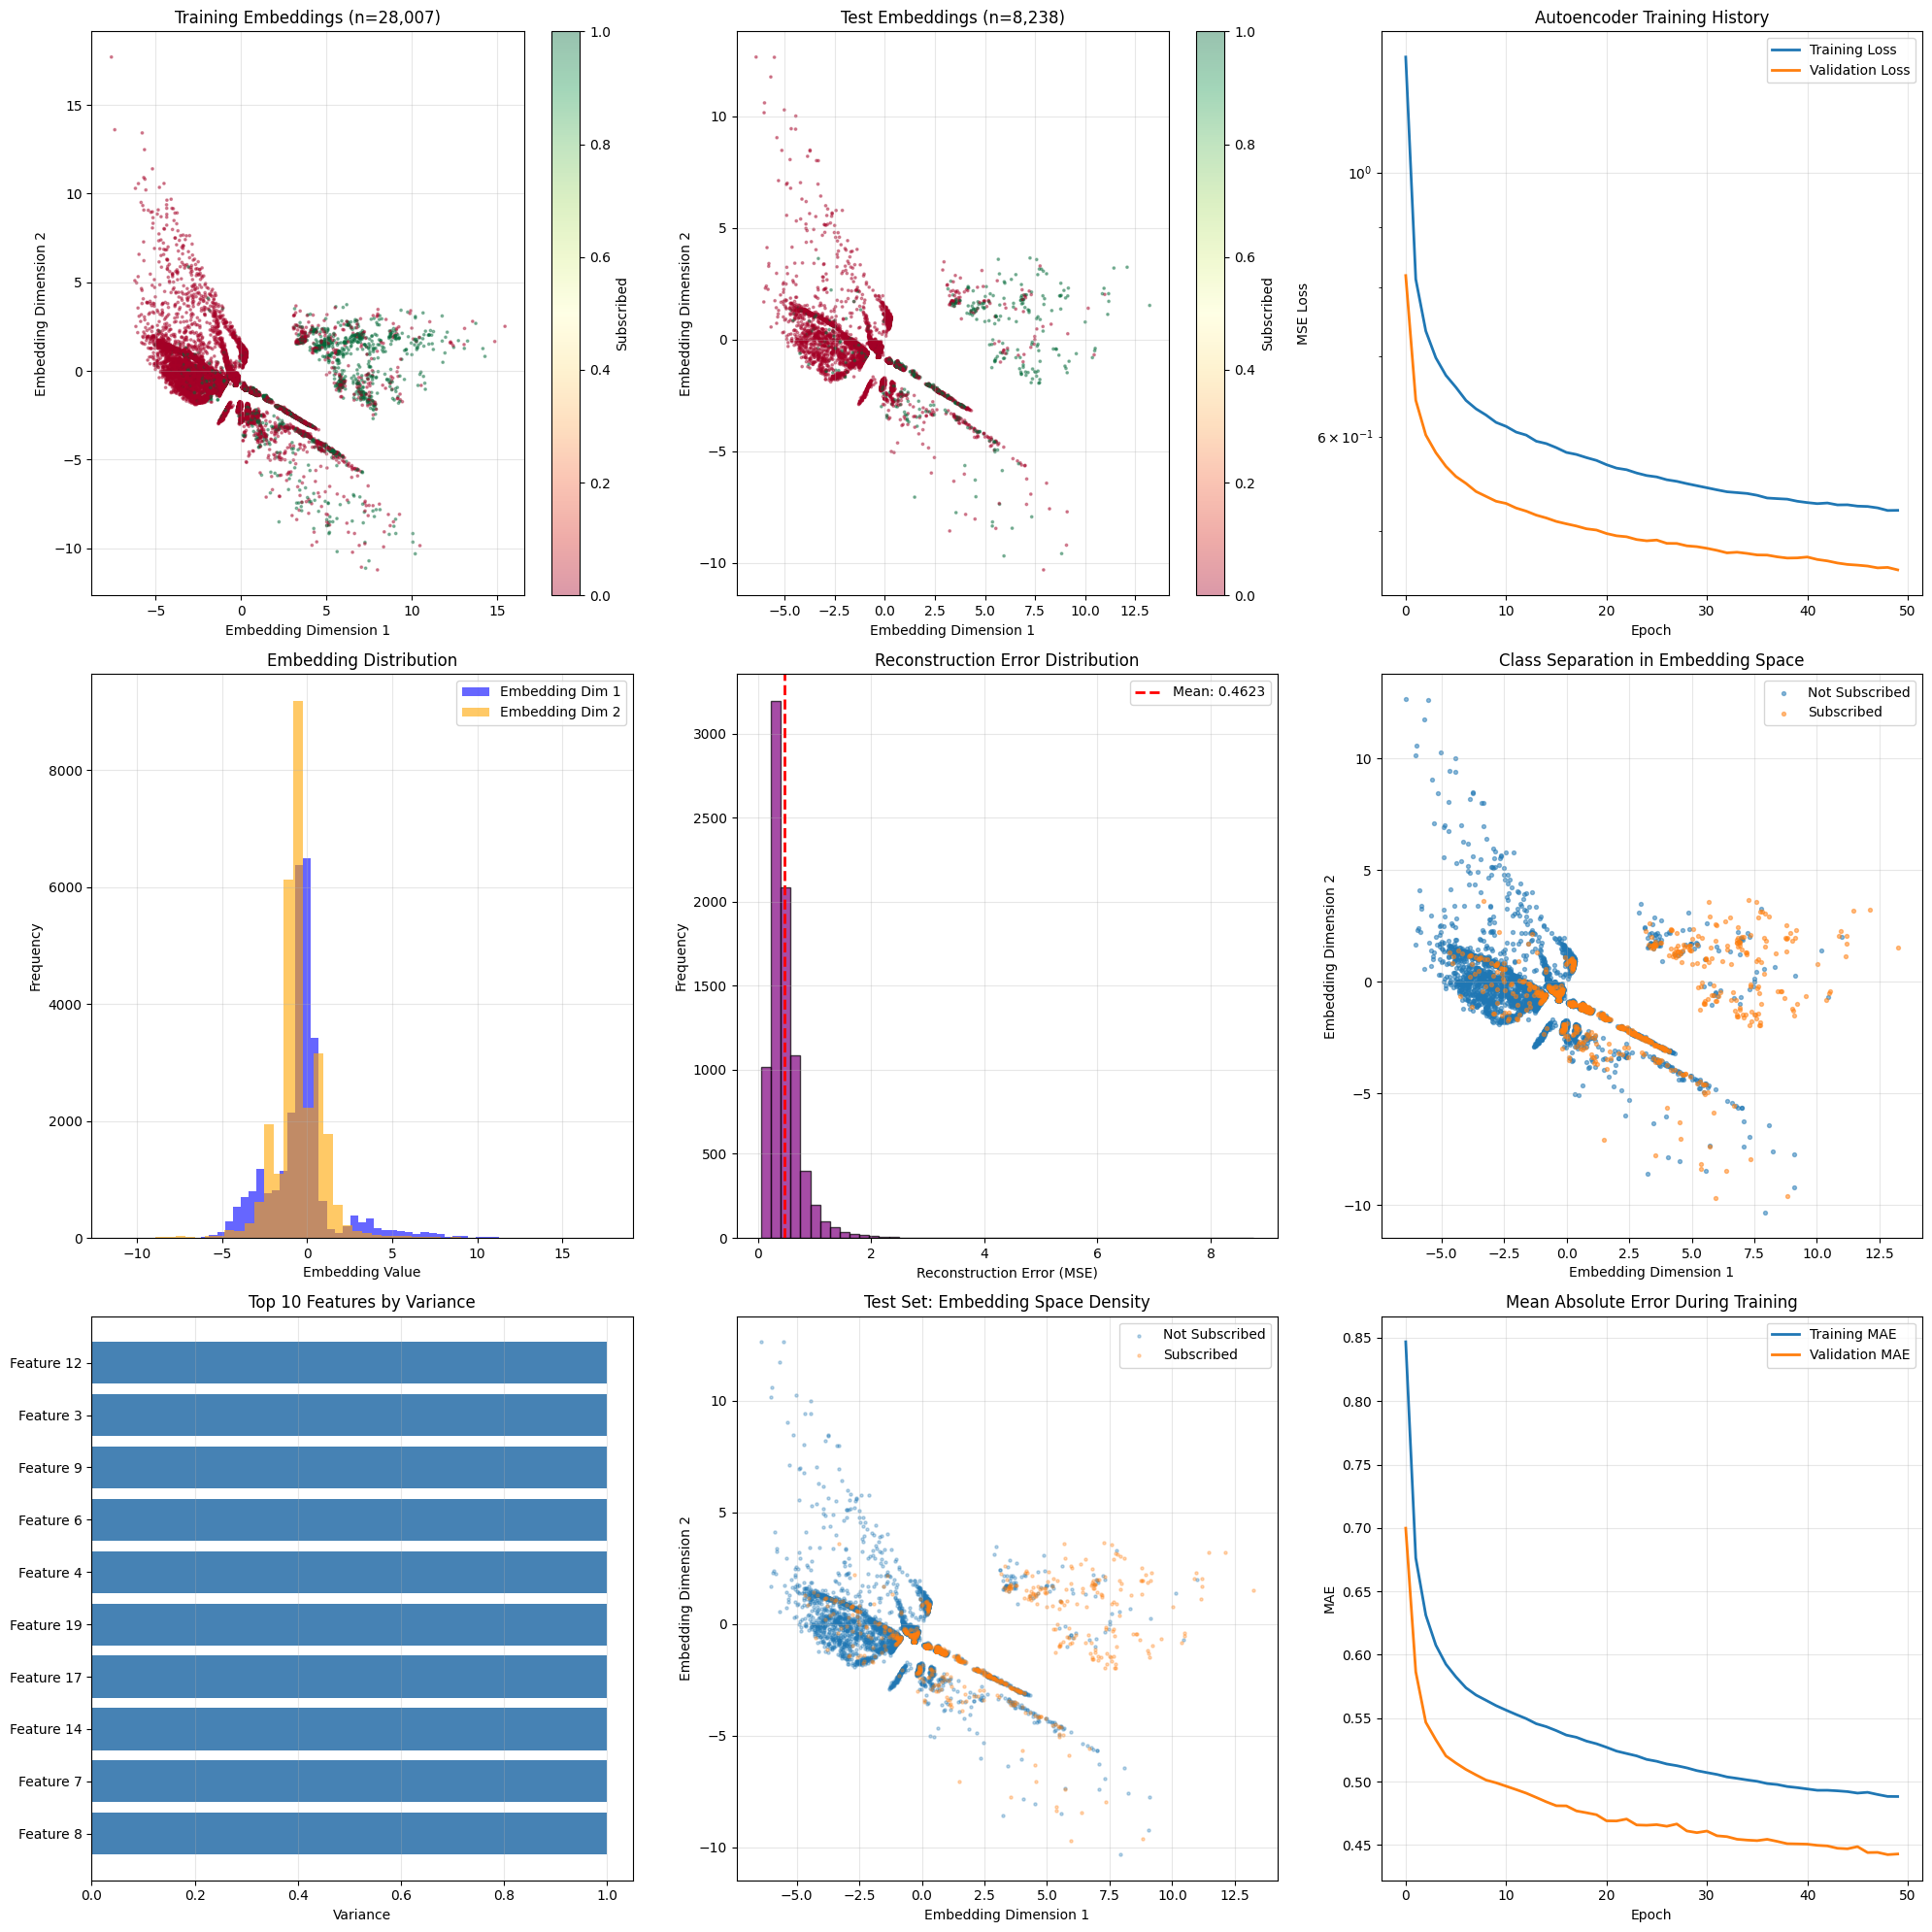

In [15]:
# 7. Visualizations
print("\nCreating visualizations...")
fig = plt.figure(figsize=(20, 20))

# Training embeddings
ax1 = plt.subplot(3, 3, 1)
scatter = ax1.scatter(train_embeddings[:, 0], train_embeddings[:, 1],
                     c=y_train, cmap='RdYlGn', alpha=0.4, s=3)
plt.colorbar(scatter, label='Subscribed')
ax1.set_xlabel('Embedding Dimension 1')
ax1.set_ylabel('Embedding Dimension 2')
ax1.set_title(f'Training Embeddings (n={len(y_train):,})')
ax1.grid(True, alpha=0.3)

# Test embeddings
ax2 = plt.subplot(3, 3, 2)
scatter = ax2.scatter(test_embeddings[:, 0], test_embeddings[:, 1],
                     c=y_test, cmap='RdYlGn', alpha=0.4, s=3)
plt.colorbar(scatter, label='Subscribed')
ax2.set_xlabel('Embedding Dimension 1')
ax2.set_ylabel('Embedding Dimension 2')
ax2.set_title(f'Test Embeddings (n={len(y_test):,})')
ax2.grid(True, alpha=0.3)

# Training history
ax3 = plt.subplot(3, 3, 3)
ax3.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax3.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('MSE Loss')
ax3.set_title('Autoencoder Training History')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# Embedding distributions
ax4 = plt.subplot(3, 3, 4)
ax4.hist(train_embeddings[:, 0], bins=50, alpha=0.6, label='Embedding Dim 1', color='blue')
ax4.hist(train_embeddings[:, 1], bins=50, alpha=0.6, label='Embedding Dim 2', color='orange')
ax4.set_xlabel('Embedding Value')
ax4.set_ylabel('Frequency')
ax4.set_title('Embedding Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Reconstruction error
ax5 = plt.subplot(3, 3, 5)
reconstructed = autoencoder.predict(X_test_scaled, batch_size=1024, verbose=0)
reconstruction_errors = np.mean((X_test_scaled - reconstructed) ** 2, axis=1)
ax5.hist(reconstruction_errors, bins=50, edgecolor='black', alpha=0.7, color='purple')
ax5.axvline(np.mean(reconstruction_errors), color='red', linestyle='--',
           linewidth=2, label=f'Mean: {np.mean(reconstruction_errors):.4f}')
ax5.set_xlabel('Reconstruction Error (MSE)')
ax5.set_ylabel('Frequency')
ax5.set_title('Reconstruction Error Distribution')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Class separation
ax6 = plt.subplot(3, 3, 6)
for class_idx in [0, 1]:
    mask = y_test == class_idx
    label = 'Subscribed' if class_idx == 1 else 'Not Subscribed'
    ax6.scatter(test_embeddings[mask, 0], test_embeddings[mask, 1],
               label=label, alpha=0.5, s=8)
ax6.set_xlabel('Embedding Dimension 1')
ax6.set_ylabel('Embedding Dimension 2')
ax6.set_title('Class Separation in Embedding Space')
ax6.legend()
ax6.grid(True, alpha=0.3)

# Feature importance (variance in original space)
ax7 = plt.subplot(3, 3, 7)
feature_variance = np.var(X_train_scaled, axis=0)
top_features_idx = np.argsort(feature_variance)[-10:]
ax7.barh(range(10), feature_variance[top_features_idx], color='steelblue')
ax7.set_yticks(range(10))
ax7.set_yticklabels([f'Feature {i}' for i in top_features_idx])
ax7.set_xlabel('Variance')
ax7.set_title('Top 10 Features by Variance')
ax7.grid(True, alpha=0.3, axis='x')

# Embedding by class (density)
ax8 = plt.subplot(3, 3, 8)
for class_idx in [0, 1]:
    mask = y_test == class_idx
    label = 'Subscribed' if class_idx == 1 else 'Not Subscribed'
    ax8.scatter(test_embeddings[mask, 0], test_embeddings[mask, 1],
               label=label, alpha=0.3, s=5)
ax8.set_xlabel('Embedding Dimension 1')
ax8.set_ylabel('Embedding Dimension 2')
ax8.set_title('Test Set: Embedding Space Density')
ax8.legend()
ax8.grid(True, alpha=0.3)

# MAE over epochs
ax9 = plt.subplot(3, 3, 9)
ax9.plot(history.history['mae'], label='Training MAE', linewidth=2)
ax9.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
ax9.set_xlabel('Epoch')
ax9.set_ylabel('MAE')
ax9.set_title('Mean Absolute Error During Training')
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bank_marketing_autoencoder.png', dpi=150, bbox_inches='tight')
print("Visualization saved as 'bank_marketing_autoencoder.png'")
plt.show()


In [16]:
# 8. Classification on Embeddings
print("\n" + "="*70)
print("CLASSIFICATION ON 2D AUTOENCODER EMBEDDINGS")
print("="*70)

# Random Forest
print("\n[1] Random Forest Classifier:")
start_time = time.time()
rf_embeddings = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_embeddings.fit(train_embeddings, y_train)
rf_time = time.time() - start_time
y_pred_rf = rf_embeddings.predict(test_embeddings)
y_proba_rf = rf_embeddings.predict_proba(test_embeddings)[:, 1]

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_proba_rf)

print(f"Training time: {rf_time:.2f}s (vs {baseline_time:.2f}s baseline)")
print(f"Accuracy: {rf_acc:.4f} (vs {baseline_acc:.4f} baseline)")
print(f"ROC AUC: {rf_auc:.4f} (vs {baseline_auc:.4f} baseline)")
print(f"Performance retention: {(rf_acc/baseline_acc)*100:.1f}%")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Logistic Regression
print("\n[2] Logistic Regression:")
start_time = time.time()
lr_embeddings = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
lr_embeddings.fit(train_embeddings, y_train)
lr_time = time.time() - start_time
y_pred_lr = lr_embeddings.predict(test_embeddings)
y_proba_lr = lr_embeddings.predict_proba(test_embeddings)[:, 1]

lr_acc = accuracy_score(y_test, y_pred_lr)
lr_auc = roc_auc_score(y_test, y_proba_lr)

print(f"Training time: {lr_time:.2f}s")
print(f"Accuracy: {lr_acc:.4f}")
print(f"ROC AUC: {lr_auc:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))




CLASSIFICATION ON 2D AUTOENCODER EMBEDDINGS

[1] Random Forest Classifier:
Training time: 6.68s (vs 3.13s baseline)
Accuracy: 0.8865 (vs 0.9190 baseline)
ROC AUC: 0.7603 (vs 0.9504 baseline)
Performance retention: 96.5%
Confusion Matrix:
[[7063  247]
 [ 688  240]]

[2] Logistic Regression:
Training time: 1.86s
Accuracy: 0.8960
ROC AUC: 0.7756
Confusion Matrix:
[[7239   71]
 [ 786  142]]


In [17]:
# 9. Final Summary
print("\n" + "="*70)
print("FINAL SUMMARY - UCI BANK MARKETING DATASET")
print("="*70)
print(f"Dataset: 41,188 real samples from Portuguese banking institution")
print(f"Features: {input_dim} → {encoding_dim} (compression: {input_dim/encoding_dim:.1f}x)")
print(f"Task: Predict term deposit subscription (binary classification)")
print(f"\nReconstruction Quality:")
print(f"  Mean error: {np.mean(reconstruction_errors):.6f}")
print(f"  Std error:  {np.std(reconstruction_errors):.6f}")
print(f"\nClassification Performance:")
print(f"  Baseline ({input_dim}D):  Acc={baseline_acc:.4f}, AUC={baseline_auc:.4f}")
print(f"  RF on 2D embeddings:      Acc={rf_acc:.4f}, AUC={rf_auc:.4f} ({(rf_acc/baseline_acc)*100:.1f}% retention)")
print(f"  LR on 2D embeddings:      Acc={lr_acc:.4f}, AUC={lr_auc:.4f} ({(lr_acc/baseline_acc)*100:.1f}% retention)")
print(f"\nTraining Speed (classifier only):")
print(f"  Baseline: {baseline_time:.2f}s")
print(f"  RF on embeddings: {rf_time:.2f}s ({baseline_time/rf_time:.1f}x faster)")
print(f"  LR on embeddings: {lr_time:.2f}s ({baseline_time/lr_time:.1f}x faster)")
print(f"\nAutoencoder training: {training_time:.1f}s (one-time cost)")
print("="*70)


FINAL SUMMARY - UCI BANK MARKETING DATASET
Dataset: 41,188 real samples from Portuguese banking institution
Features: 20 → 2 (compression: 10.0x)
Task: Predict term deposit subscription (binary classification)

Reconstruction Quality:
  Mean error: 0.462307
  Std error:  0.309114

Classification Performance:
  Baseline (20D):  Acc=0.9190, AUC=0.9504
  RF on 2D embeddings:      Acc=0.8865, AUC=0.7603 (96.5% retention)
  LR on 2D embeddings:      Acc=0.8960, AUC=0.7756 (97.5% retention)

Training Speed (classifier only):
  Baseline: 3.13s
  RF on embeddings: 6.68s (0.5x faster)
  LR on embeddings: 1.86s (1.7x faster)

Autoencoder training: 51.7s (one-time cost)
